<h1 style="font-size:2.5rem;color:green;"> Seattle City Light Electricity Usage and CO2 Emissions</h1>

## Introducton
This analysis focuses on the utilization of energy (electricity) and CO2 emissions across various neighborhoods and sectors (Residential, Commercial, and Industrial) in the city of Seattle. The data is sourced directly from Seattle City Light through data.gov, with utility energy consumption and CO2 emission information organized by aggregated sector, quarter, and census tract. This analysis explores basic statistics and comparisons, utilizes visualizations to enhance comprehension, and maps the overall energy consumption and CO2 emissions within the city.

## Data Overview

In [4]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
from matplotlib.colors import Normalize

# read data and view data sample

energy_data = pd.read_csv("/Users/yilikalademe/Documents/_DataAnalysisProjects/"
                          "City_Light_Usage_Data_for_OSE_Climate_Portal.csv")
print(energy_data.shape)
print(energy_data.head())

(6624, 16)
   OBJECTID1  OBJECTID             ID  CAL_YEAR CAL_QTR       Sector  \
0          1        21  17-1-C-001100      2017      Q1   Commercial   
1          2        21  17-1-R-001100      2017      Q1  Residential   
2          3        21  17-2-C-001100      2017      Q2   Commercial   
3          4        21  17-2-R-001100      2017      Q2  Residential   
4          5        21  17-3-C-001100      2017      Q3   Commercial   

   CENSUS_TRACT  GRPD_NUMBER_ACCTS   USAGE_MMBTU  EMISSIONS_MTCO2E  \
0   53033001100               48.0   2709.245984         16.700293   
1   53033001100             1069.0  12372.876867         76.268698   
2   53033001100               48.0   1975.175245         12.175345   
3   53033001100             1070.0   8243.965678         50.817327   
4   53033001100               49.0   2014.189654         12.415837   

  RSE_Quintile  USAGEPERCAPITA_MMBTU  EMISSIONSPERCAPITA_MTCO2E  Ind_Grp_Flag  \
0       Middle             56.442625                  

The dataset includes quarterly data on energy consumption measured in units of 1 million British thermal units (MMBTU) and quarterly emissions data measured in metric tons of carbon dioxide equivalent (MTCO2E), accompanied by per capita measurements. The data is also aggregated by sectors, and census tract is used to indicate the location of each sectors. SHAPE_Length and SHAPE_Area data is also provides, from which geographical mapping of the data can be visualized.

## Data Analysis End Goal

By the end of this analysis I would be addressing the following topics:
1. Energy consumption and CO2 emission compared and contrasted by sector for calendar year and quarter
2. Energy consumption and CO2 emission mapped out geographically
3. Identify key relationships between usage, emissions, sector, and neighborhoods
4. Project and recommend key future trends


## Data Cleaning and Testing

### Data Inspection and Cleaning
Below, I inspect the data for any inconsistency, missing values, or errors. 

In [6]:
# Checking the data types of all of the columns

data_types = energy_data.dtypes
print(data_types)

OBJECTID1                      int64
OBJECTID                       int64
ID                            object
CAL_YEAR                       int64
CAL_QTR                       object
Sector                        object
CENSUS_TRACT                   int64
GRPD_NUMBER_ACCTS            float64
USAGE_MMBTU                  float64
EMISSIONS_MTCO2E             float64
RSE_Quintile                  object
USAGEPERCAPITA_MMBTU         float64
EMISSIONSPERCAPITA_MTCO2E    float64
Ind_Grp_Flag                   int64
SHAPE_Length                 float64
SHAPE_Area                   float64
dtype: object


In [7]:
# Checking to see if there are any missing values throughout the dataset

table_null_values = energy_data.isnull().any().any()

if table_null_values:
    print('There are empty cells in the dataset.')
else:
    print('There are no empty cells in the dataset.')

There are no empty cells in the dataset.


In [8]:
# Checking to see if there are any duplicated rows

duplicated_rows = energy_data.duplicated().any()

if duplicated_rows:
    print('There are duplicated rows in the dataset.')
else:
    print('There are no duplicated rows in the dataset.')

There are no duplicated rows in the dataset.


In [9]:
# Taking a look at the period of time this data encompasses

min_year = energy_data['CAL_YEAR'].min()
max_year = energy_data['CAL_YEAR'].max()
print('Minimum year:', min_year)
print('Maximum year:', max_year)

Minimum year: 2017
Maximum year: 2022


In [10]:
# Checking for any inconsistency in the calander year column.

distinct_years = energy_data['CAL_YEAR'].unique()
print('Distinct values in CAL_YEAR:', distinct_years)


Distinct values in CAL_YEAR: [2017 2018 2019 2020 2021 2022]


In [11]:
# Inspecting the Sector column
#  Checking for any inconsistency in the Sector column.

distinct_sector = energy_data['Sector'].unique()
print('Distinct values in Sector:', distinct_sector)

Distinct values in Sector: ['Commercial' 'Residential' 'Industrial']


In [729]:
# Inspecting Geographic data

dl = pd.DataFrame(energy_data)
distinct_length = dl['SHAPE_Length'].value_counts()
print('Distinct length values in ', distinct_length)

da = pd.DataFrame(energy_data)
distinct_area = da['SHAPE_Area'].value_counts()
print('Distinct area values in ', distinct_area)

Distinct length values in  SHAPE_Length
31646.66    72
65404.07    72
51389.08    72
33720.15    72
26457.35    72
            ..
13202.53    48
19268.39    48
7060.26     48
20845.20    48
19247.35    48
Name: count, Length: 134, dtype: int64
Distinct area values in  SHAPE_Area
29836536.55    72
70244734.69    72
33263478.95    72
22228102.11    72
26850774.32    72
               ..
10210023.82    48
18546347.82    48
2683148.65     48
19740182.72    48
5237445.92     48
Name: count, Length: 134, dtype: int64


The outputs inducate that there are 134 unique values for each columns and only displays a few of those values. I will further explore this geographic data during the analysis process.

### Data Testing

The dataset seems to be clean of any inconsistencies and errors. I would run a sample perliminary analysis to see if I would run into any problems or errors during the analysis process.

In [12]:
# Calculating the sum of energy usage aggregated by sector

total_energy_by_sector = energy_data.groupby('Sector')['USAGE_MMBTU'].sum()
print('Total energy usage grouped by', total_energy_by_sector)

Total energy usage grouped by Sector
Commercial     9.468288e+07
Industrial     1.651150e+07
Residential    5.508172e+07
Name: USAGE_MMBTU, dtype: float64


In [13]:
# Calculating the sum of energy usage aggregated by year

total_energy_by_year = energy_data.groupby('CAL_YEAR')['USAGE_MMBTU'].sum()
print('Total energy usage grouped by', total_energy_by_year)

Total energy usage grouped by CAL_YEAR
2017    2.855621e+07
2018    2.753802e+07
2019    2.741543e+07
2020    2.714645e+07
2021    2.808195e+07
2022    2.753804e+07
Name: USAGE_MMBTU, dtype: float64


Sample calculations are run without any errors and difficulties and this gives me the green light to dive into the thorough data analysis where I would address the objectives of the analysis.

## Data Analysis and Visualization


### Total Energy Usage by Sector and Calendar Year
In this first step of the data analysis process, I would calculate the total amount of energy used aggregated by sector and calendar year.

In [14]:
# Calculating the total energy aggregated by sector and calendar year

total_energy = energy_data.groupby(['CAL_YEAR','Sector'])['USAGE_MMBTU'].sum()

print(total_energy)


CAL_YEAR  Sector     
2017      Commercial     1.673254e+07
          Industrial     2.603368e+06
          Residential    9.220304e+06
2018      Commercial     1.601761e+07
          Industrial     2.729968e+06
          Residential    8.790442e+06
2019      Commercial     1.588319e+07
          Industrial     2.806668e+06
          Residential    8.725574e+06
2020      Commercial     1.513972e+07
          Industrial     2.777444e+06
          Residential    9.229289e+06
2021      Commercial     1.558493e+07
          Industrial     2.996014e+06
          Residential    9.501009e+06
2022      Commercial     1.532490e+07
          Industrial     2.598033e+06
          Residential    9.615106e+06
Name: USAGE_MMBTU, dtype: float64


I would rearrage the table to have it ready and suitable for visualization. In order to so I would need to index my data and create a pivot table.

Rearranged energy result table:


Sector,CAL_YEAR,Commercial,Industrial,Residential
0,2017,16732535.56,2603368.41,9220303.73
1,2018,16017609.53,2729967.51,8790442.16
2,2019,15883192.63,2806668.25,8725573.86
3,2020,15139715.72,2777444.17,9229288.68
4,2021,15584925.69,2996014.25,9501008.66
5,2022,15324901.89,2598033.45,9615105.69


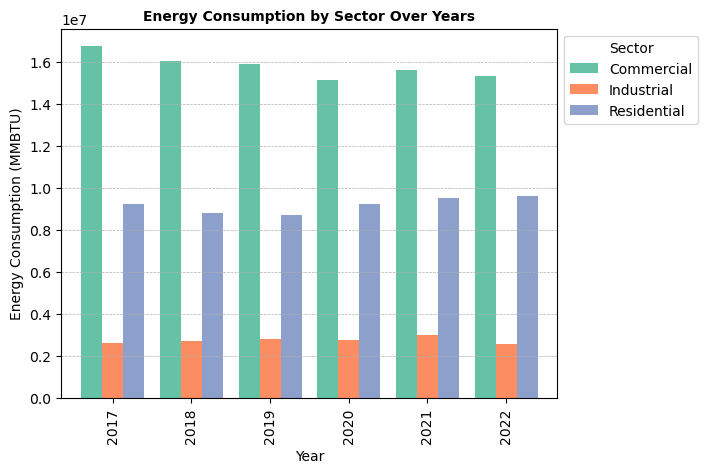

In [62]:
# Pivoting the result table so that the results become rearranged

energy_ = pd.DataFrame(total_energy)
energy_result_pivoted = energy_.pivot_table(index='CAL_YEAR', columns='Sector', 
                                     values='USAGE_MMBTU', fill_value=0).reset_index()

print('Rearranged energy result table:')

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(energy_result_pivoted)

# Creating a visualization for energy consumption by sector and calendar year

colors = sns.color_palette('Set2')

energy_result_pivoted.set_index('CAL_YEAR', inplace=True)

plot_1 = energy_result_pivoted.plot(kind='bar', color=colors, width=0.8)
plt.xlabel('Year')
plt.ylabel('Energy Consumption (MMBTU)')
plt.title('Energy Consumption by Sector Over Years', size=10, weight='bold')
plt.legend(title='Sector', loc='upper left', bbox_to_anchor=(1, 1))

plot_1.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.show()


For the plotting of my analysis, I wanted to explore with more color palettes. Therefore, I installed and imported seaborn at this stage of the analysis.

### Total Energy Usage Per Capita
**Describe

Rearranged energy per capita result table:


Sector,CAL_YEAR,Commercial,Industrial,Residential
0,2017,67314.61,936709.87,4156.16
1,2018,67601.39,976374.01,3943.16
2,2019,68845.02,1020672.65,3823.29
3,2020,67985.58,1017394.06,4002.87
4,2021,70866.91,1164303.27,4105.27
5,2022,68670.30,1038299.73,4092.43


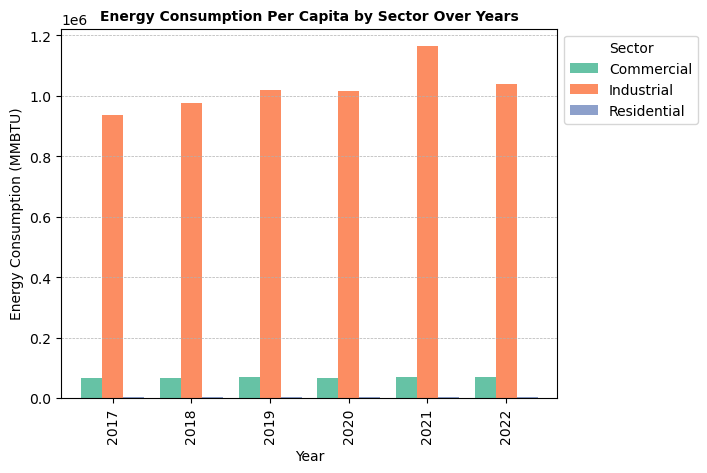

In [16]:
# Calculating the total energy per capita aggregated by sector and calendar year

total_energy_per_capita  = energy_data.groupby(
    ['CAL_YEAR','Sector'])['USAGEPERCAPITA_MMBTU'].sum().reset_index()

# Pivoting the result table so that the results become rearranged
energy_per_capita = pd.DataFrame(total_energy_per_capita)
energy_per_capita_pivoted = energy_per_capita.pivot_table(index='CAL_YEAR', 
                                                          columns='Sector', 
                                                          values='USAGEPERCAPITA_MMBTU', 
                                                          fill_value=0).reset_index()

print("Rearranged energy per capita result table:")

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(energy_per_capita_pivoted)

# Creating a visualization for energy consumption per capita by sector and calendar year

colors = sns.color_palette("Set2")

energy_per_capita_pivoted.set_index("CAL_YEAR", inplace=True)

plot_2 = energy_per_capita_pivoted.plot(kind='bar', color=colors, width=0.8)
plt.xlabel("Year")
plt.ylabel("Energy Consumption (MMBTU)")
plt.title("Energy Consumption Per Capita by Sector Over Years", size=10, weight='bold')
plt.legend(title='Sector', loc='upper left', bbox_to_anchor=(1, 1))

plot_2.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.show()

### Total CO2 Emissions by Sector and Calendar Year
In this step of the data analysis process, I would calculate the toal amount of CO2 emission aggregated by sector and calendar year.

Rearranged emissions Result table:


Sector,CAL_YEAR,Commercial,Industrial,Residential
0,2017,103142.44,16047.64,56835.65
1,2018,68243.97,11631.19,37452.20
2,2019,87772.08,15509.92,48218.37
3,2020,39527.35,7251.46,24096.18
4,2021,40689.73,7822.11,24805.60
5,2022,40010.85,6783.05,25103.49


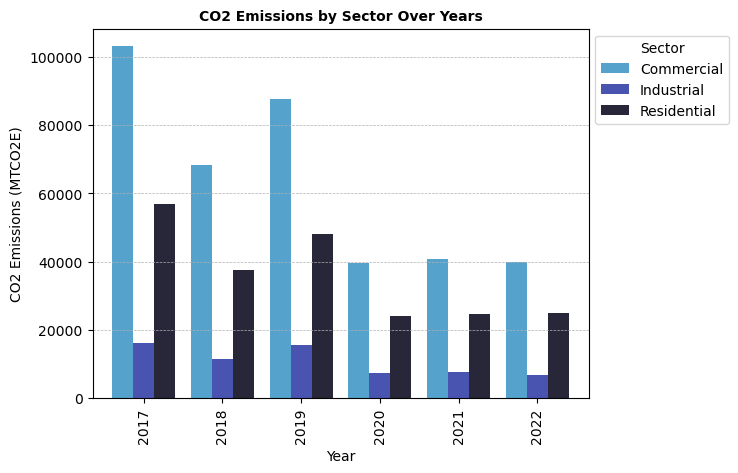

In [17]:
# Calculating total CO2 emissions

total_emissions  = energy_data.groupby(
['CAL_YEAR','Sector'])['EMISSIONS_MTCO2E'].sum().reset_index()

# Pivoting the result table so that the results become rearranged

emissions_ = pd.DataFrame(total_emissions)
emissions_result_pivoted = emissions_.pivot_table(index='CAL_YEAR', 
                                                  columns='Sector', 
                                                  values='EMISSIONS_MTCO2E', 
                                                  fill_value=0).reset_index()

print("Rearranged emissions Result table:")

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(emissions_result_pivoted)

# Creating a visualization for energy consumption by sector and calendar year

colors = sns.color_palette("icefire")

emissions_result_pivoted.set_index("CAL_YEAR", inplace=True)

plot_3 = emissions_result_pivoted.plot(kind='bar', color=colors, width=0.8)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (MTCO2E)")
plt.title("CO2 Emissions by Sector Over Years", size=10, weight='bold')
plt.legend(title='Sector', loc='upper left', bbox_to_anchor=(1, 1))

plot_3.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.show()


### Total CO2 Emissions Per Capita
In this step of the data analysis process, I would calculate the toal amount of CO2 emission per capita aggregated by sector and calendar year.

Rearranged emissions per capita Result table:


Sector,CAL_YEAR,Commercial,Industrial,Residential
0,2017,414.94,5774.05,25.62
1,2018,288.02,4159.90,16.80
2,2019,380.44,5640.34,21.13
3,2020,177.50,2656.25,10.45
4,2021,185.02,3039.81,10.72
5,2022,179.29,2710.83,10.68


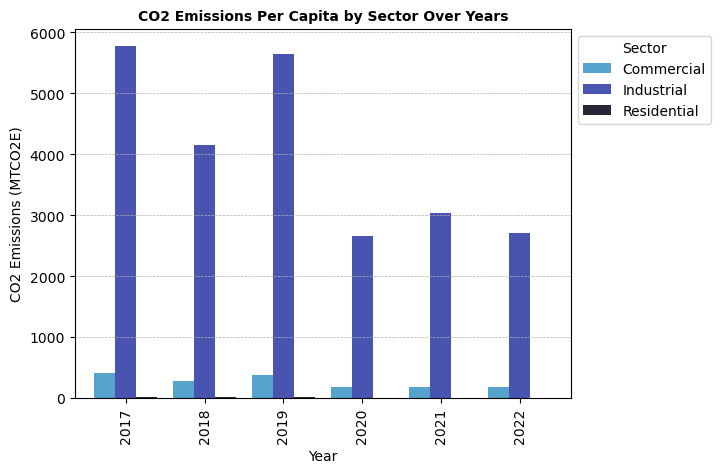

In [18]:
# CO2 emissions per capita aggregated by sector and calendar year

total_emissions_per_capita  = energy_data.groupby(
    ['CAL_YEAR','Sector'])['EMISSIONSPERCAPITA_MTCO2E'].sum().reset_index()

# Pivoting the result table so that the results become rearranged
emissions_per_capita = pd.DataFrame(total_emissions_per_capita )
emissions_per_capita_pivoted = emissions_per_capita.pivot_table(index='CAL_YEAR', 
                                                                columns='Sector', 
                                                    values='EMISSIONSPERCAPITA_MTCO2E', 
                                                                fill_value=0).reset_index()

print("Rearranged emissions per capita Result table:")

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(emissions_per_capita_pivoted)

# Creating a visualization for energy consumption per capita by sector and calendar year

colors = sns.color_palette("icefire")

emissions_per_capita_pivoted.set_index("CAL_YEAR", inplace=True)

plot_4 = emissions_per_capita_pivoted.plot(kind='bar', color=colors, width=0.8)
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (MTCO2E)")
plt.title("CO2 Emissions Per Capita by Sector Over Years", size=10, weight='bold')
plt.legend(title='Sector', loc='upper left', bbox_to_anchor=(1, 1))

plot_4.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.show()

### Total Energy Usage by Sector and Quarter

Rearranged quarterly energy result table:


Sector,CAL_QTR,Commercial,Industrial,Residential
0,Q1,25339665.86,4148370.69,17068256.76
1,Q2,21995129.08,3990593.71,11757061.14
2,Q3,23029794.17,4032120.16,10689961.80
3,Q4,24318291.91,4340411.50,15566443.08


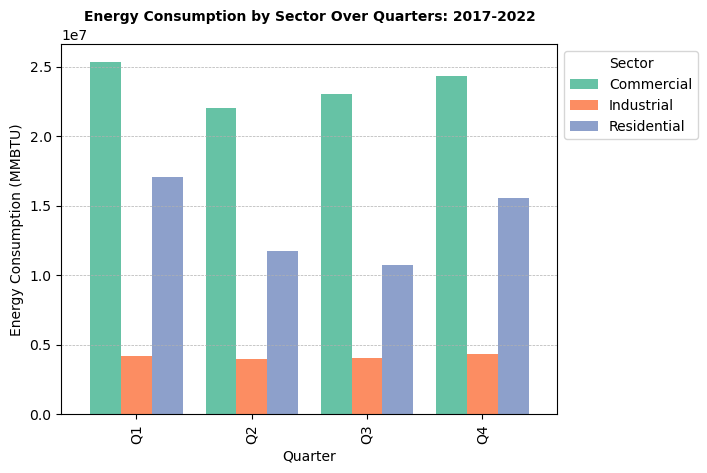

In [19]:
# Calculating the total energy aggregated by sector and quarter
total_energy_quarterly  = energy_data.groupby(
    ['CAL_QTR','Sector'])['USAGE_MMBTU'].sum().reset_index()

# Pivoting the result table so that the results become rearranged
energy_quarterly = pd.DataFrame(total_energy_quarterly)
q_energy_result_pivoted = energy_quarterly.pivot_table(index='CAL_QTR', 
                                                       columns='Sector', 
                                                       values='USAGE_MMBTU', 
                                                       fill_value=0).reset_index()

print("Rearranged quarterly energy result table:")

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(q_energy_result_pivoted)

# Creating a visualization for energy consumption by sector and quarter

colors = sns.color_palette("Set2")

q_energy_result_pivoted.set_index("CAL_QTR", inplace=True)

plot_5 = q_energy_result_pivoted.plot(kind='bar', color=colors, width=0.8)
plt.xlabel("Quarter")
plt.ylabel("Energy Consumption (MMBTU)")
plt.title("Energy Consumption by Sector Over Quarters: 2017-2022", size=10, weight='bold')
plt.legend(title='Sector', loc='upper left', bbox_to_anchor=(1, 1))

plot_5.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.show()


### Total CO2 Emissions by Sector and Quarter

Rearranged quarterly emissions Result table:


Sector,CAL_QTR,Commercial,Industrial,Residential
0,Q1,100886.20,15982.09,67533.20
1,Q2,89139.19,15979.03,45969.60
2,Q3,92888.62,16329.80,42008.89
3,Q4,96472.40,16754.45,60999.81


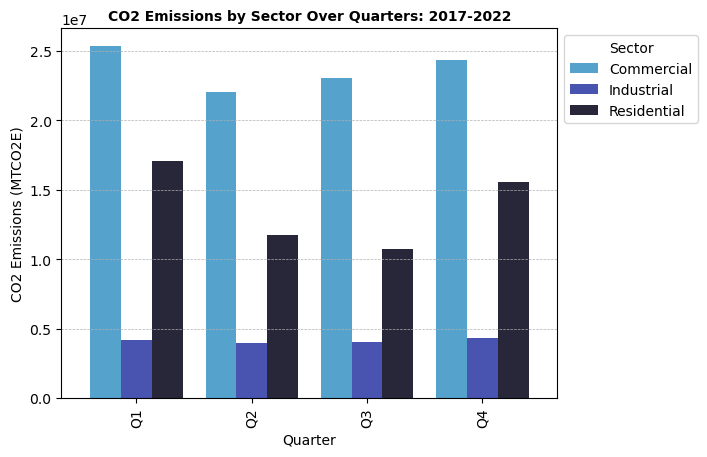

In [20]:
# Calculating the total CO2 emission aggregated by sector and quarter
total_emissions_quarterly  = energy_data.groupby(
    ['CAL_QTR','Sector'])['EMISSIONS_MTCO2E'].sum().reset_index()

# Pivoting the result table so that the results become rearranged
emissions_quarterly = pd.DataFrame(total_emissions_quarterly)
q_emissions_result_pivoted = emissions_quarterly.pivot_table(index='CAL_QTR',
                                                             columns='Sector',
                                                             values='EMISSIONS_MTCO2E',
                                                             fill_value=0).reset_index()

print("Rearranged quarterly emissions Result table:")

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(q_emissions_result_pivoted)

# Creating a visualization for energy consumption by sector and quarter

colors = sns.color_palette("icefire")

q_emissions_result_pivoted.set_index("CAL_QTR", inplace=True)

plot_6 = q_energy_result_pivoted.plot(kind='bar', color=colors, width=0.8)
plt.xlabel("Quarter")
plt.ylabel("CO2 Emissions (MTCO2E)")
plt.title("CO2 Emissions by Sector Over Quarters: 2017-2022", size=10, weight='bold')
plt.legend(title='Sector', loc='upper left', bbox_to_anchor=(1, 1))

plot_6.yaxis.grid(True, linestyle='--', linewidth=0.5)

plt.show()

### GIS Data Analysis (SHAPE_Length and SHAPE_Area)

In this initial stage of the portion of the analysis, I would create a visualization to see the distribution of the shape data based on the Sector category.

#### Distribution by Sector

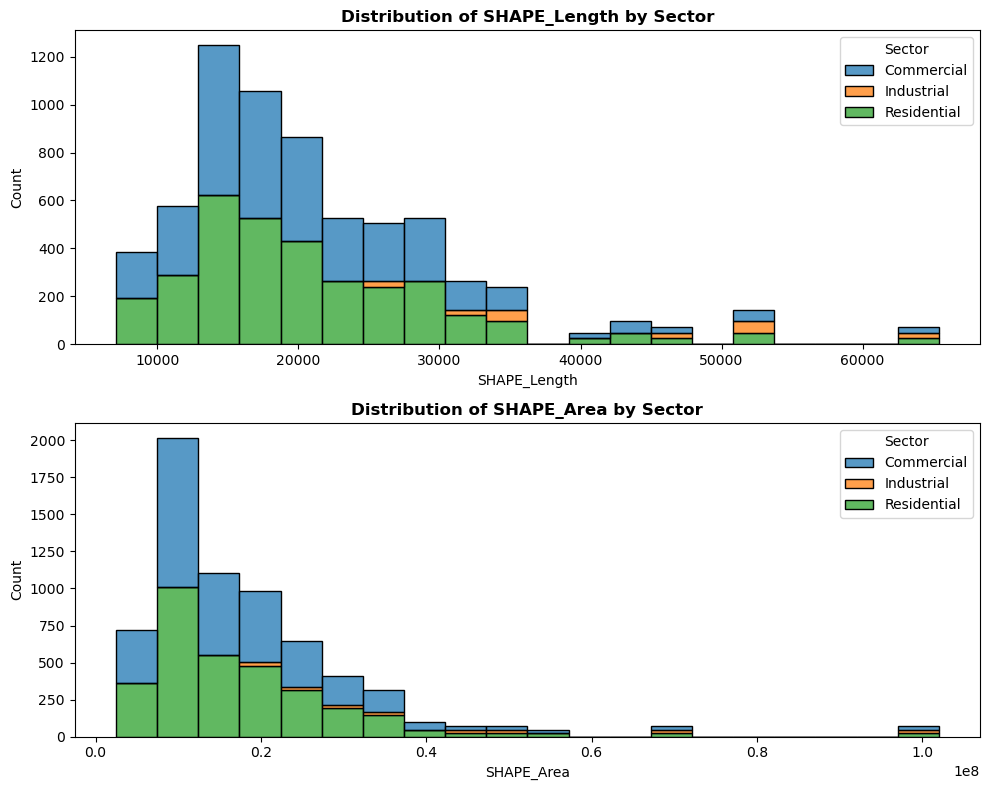

In [21]:
# Setting the category in the DataFrame
category_column_1 = 'Sector'
energy_data[category_column_1] = pd.Categorical(energy_data[category_column_1])

# Creating subplots for SHAPE_Length and SHAPE_Area
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
palette = sns.color_palette('Set2', n_colors=len(energy_data[category_column_1].unique()))

# Distribution plot for SHAPE_Length by Sector
sns.histplot(data=energy_data, x='SHAPE_Length', hue=category_column_1, 
             multiple='stack', bins=20, ax=axes[0])
axes[0].set_title('Distribution of SHAPE_Length by Sector', size=12, weight='bold')
axes[0].set_xlabel('SHAPE_Length')

# Distribution plot for SHAPE_Area by Sector
sns.histplot(data=energy_data, x='SHAPE_Area', hue=category_column_1, 
             multiple='stack', bins=20, ax=axes[1])
axes[1].set_title('Distribution of SHAPE_Area by Sector', size=12, weight='bold')
axes[1].set_xlabel('SHAPE_Area')

plt.tight_layout()
plt.show()

#### Geometric Mapping

In this section of my analysis, I'm going to create a choropleth map showing the distribution of energy usage and CO2 emissions. In order to do that I need to import the library 'geopandas' first, and then, utilize my SHAPE_Length and SHAPE_Area data to obtain geometric data. The SHAPE data can be converted into geometric data through Python's Shapely polygons.

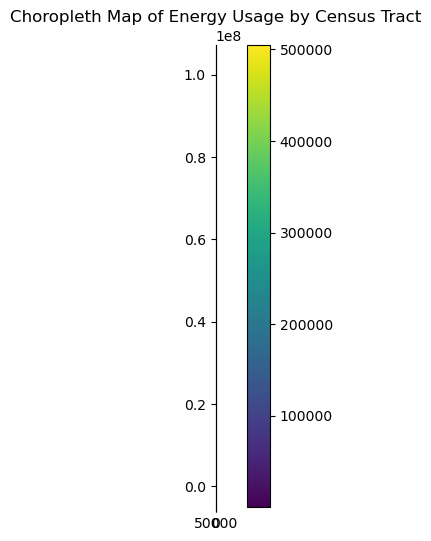

In [22]:
# Create Shapely geometries using 'SHAPE_Length' and 'SHAPE_Area'
energy_data['geometry'] = energy_data.apply(lambda row: Polygon([(0,0),
                                                                 (row['SHAPE_Length'], 0),
                                                                 (row['SHAPE_Length'],
                                                                  row['SHAPE_Area']),
                                                                 (0, row['SHAPE_Area'])]), 
                                                                    axis=1)

# Convert DataFrame to GeoDataFrame
g_energy_data = gpd.GeoDataFrame(energy_data, geometry='geometry')

# Plot choropleth map for energy usage
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
g_energy_data.plot(ax=ax, column='USAGE_MMBTU', cmap='viridis', 
                   linewidth=0.8, edgecolor='0.8', legend=True)
ax.set_title('Choropleth Map of Energy Usage by Census Tract')
plt.show()

I've encountered an issue with the choropleth map I wanted to generate. Instead of the expected map, I only received the legend. Upon running the code for .head() and .shape() on the newly created 'geometry' column, I found that its data type is 'object' when I actually need it to be 'float'. Consequently, I need to convert the data type. or I need to explore to find more data from data.gov.

In [23]:
print((energy_data['geometry']).head())
print((energy_data['geometry']).shape)

0    POLYGON ((0 0, 14316.8853745282 0, 14316.88537...
1    POLYGON ((0 0, 14316.8853745282 0, 14316.88537...
2    POLYGON ((0 0, 14316.8853745282 0, 14316.88537...
3    POLYGON ((0 0, 14316.8853745282 0, 14316.88537...
4    POLYGON ((0 0, 14316.8853745282 0, 14316.88537...
Name: geometry, dtype: object
(6624,)


 Upon recognizing the need for additional data to generate the choropleth map, I discovered that data.gov offers shapefile and GeoJSON files. I will leverage these files for further analysis and visualization of the data.

### Analyzing the Geo File 

In [25]:
# Loading the shapefile

geo_data = gpd.read_file("/Users/yilikalademe/Documents/"
                         "_DataAnalysisProjects/"
                         "City_Light_Usage_Data_for_OSE_Climate_Portal (1)/SCL_Tracts.shp")
print(geo_data.shape)
print(geo_data.head())
print(geo_data.dtypes)

#dl = pd.DataFrame(energy_data)
distinct_geo_data = geo_data['geometry'].value_counts()
print("Distinct geomerty values ", distinct_geo_data)

(6624, 17)
   OBJECTID1  OBJECTID             ID  CAL_YEAR CAL_QTR       Sector  \
0          1        21  17-1-C-001100   2017.00      Q1   Commercial   
1          2        21  17-1-R-001100   2017.00      Q1  Residential   
2          3        21  17-2-C-001100   2017.00      Q2   Commercial   
3          4        21  17-2-R-001100   2017.00      Q2  Residential   
4          5        21  17-3-C-001100   2017.00      Q3   Commercial   

      CENSUS_TRA  GRPD_NUMBE  USAGE_MMBT  EMISSIONS_ RSE_Quinti  USAGEPERCA  \
0 53033001100.00       48.00     2709.25       16.70     Middle       56.44   
1 53033001100.00     1069.00    12372.88       76.27     Middle       11.57   
2 53033001100.00       48.00     1975.18       12.18     Middle       41.15   
3 53033001100.00     1070.00     8243.97       50.82     Middle        7.70   
4 53033001100.00       49.00     2014.19       12.42     Middle       41.11   

   EMISSIONSP  Ind_Grp_Fl  SHAPE_Leng  SHAPE_Area  \
0        0.35           0   

#### Explore the Geometry Data

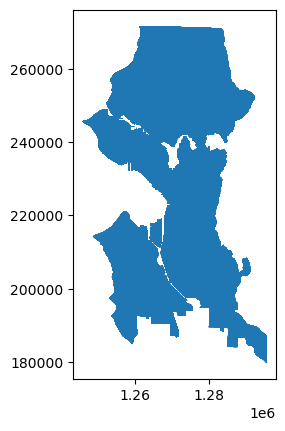

        Sector  Count
0   Commercial   3216
1   Industrial    192
2  Residential   3216


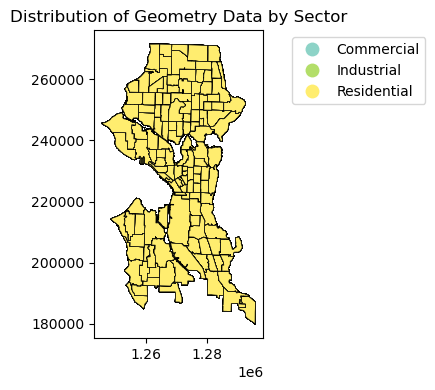

In [26]:
#plotting to see the map we are working with (map of Seattle)

geo_data.plot()
plt.show()


sector_column = 'Sector'

# Plot the choropleth map of the distribution of geometry data by sector

aggregated_data = geo_data.groupby([sector_column]).size().reset_index(name='Count')

print(aggregated_data)


fig, ax = plt.subplots(figsize=(8, 4))
geo_data.plot(ax=ax, column=sector_column, legend=True, cmap='Set3', edgecolor='black', linewidth=0.5)


legend = ax.get_legend()
legend.set_bbox_to_anchor((2, 1)) 


# Add title and show the plot
plt.title('Distribution of Geometry Data by Sector', size=12)
plt.show()

Upon reviewing the raw data, it became apparent that the geometric values for the residential and commercial sectors are identical. As a result, the choropleth map displays an overlap of these values. I intend to create separate plots for each sector to better understand the distinct spatial patterns they exhibit.

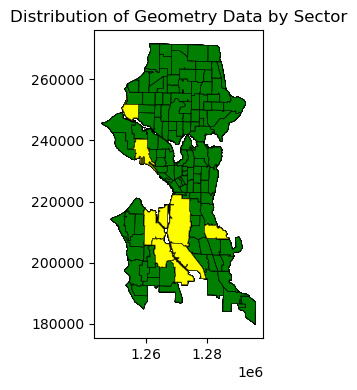

In [28]:

sector_column = 'Sector'

# Plot the choropleth map of the distribution of geometry data by sector
fig, ax = plt.subplots(figsize=(8, 4))

# Plot sector data with transparency and label
geo_data[geo_data[sector_column] == 'Commercial'].plot(ax=ax, color='blue', alpha=0.5, edgecolor='black', linewidth=0.5, label='Commercial')
geo_data[geo_data[sector_column] == 'Residential'].plot(ax=ax, color='green', alpha=0.5, edgecolor='black', linewidth=0.5, label='Residential')
geo_data[geo_data[sector_column] == 'Industrial'].plot(ax=ax, color='yellow', alpha=0.5, edgecolor='black', linewidth=0.5, label='Industrial')


#Add legend
legend = ax.get_legend()
#legend.set_bbox_to_anchor((1.5, 1)) 

plt.title('Distribution of Geometry Data by Sector')
plt.show()

#### Explore Different Columns as a Category

This approach might not seem to work out. I would explore other columns in the dataset. I would work with the grouped population data (GRPD_NUMBE)

Distinct population data number values in  GRPD_NUMBE
2.67       63
10.00      42
3.00       37
12.00      34
82.00      33
           ..
758.00      1
764.00      1
771.00      1
691.00      1
3087.00     1
Name: count, Length: 2541, dtype: int64


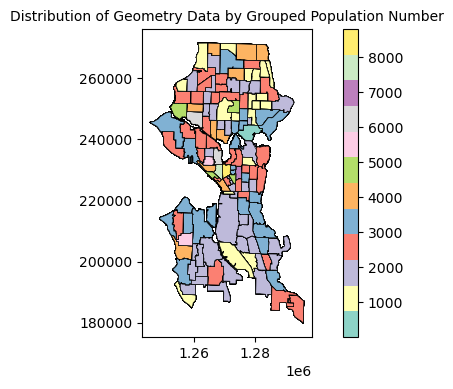

In [29]:
#exploring the grouped population data number column

dl = pd.DataFrame(energy_data)
distinct_length = geo_data['GRPD_NUMBE'].value_counts()
print("Distinct population data number values in ", distinct_length)

#GRPD_NUMBE 

grpd_column = 'GRPD_NUMBE'

# Plot the choropleth map of the distribution of geometry data by grpd

fig, ax = plt.subplots(figsize=(8, 4))
geo_data.plot(ax=ax, column=grpd_column, legend=True, cmap='Set3', edgecolor='black', linewidth=0.5)


#legend = ax.get_legend()
#legend.set_bbox_to_anchor((2, 1)) 


# Add title and show the plot
plt.title('Distribution of Geometry Data by Grouped Population Number', size=10)
plt.show()

The choropleth map depicted above illustrates variations in grouped population numbers. This is encouraging, as it suggests potential effectiveness when applying a similar mapping approach to display energy usage and CO2 emission data categorized by distinct groups.

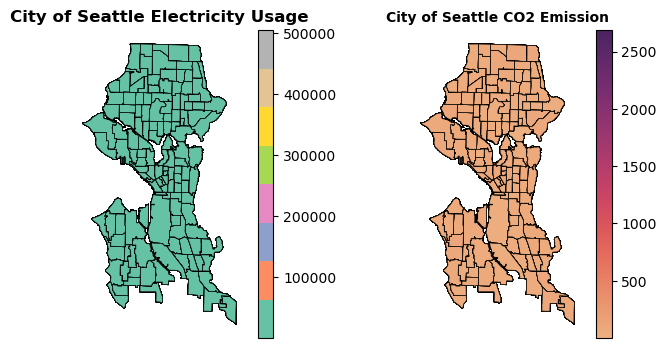

In [30]:
# Plot the geo data


grpd_column = 'GRPD_NUMBE'
energy_column = 'USAGE_MMBT'
emission_column = 'EMISSIONS_'

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

geo_data.plot(ax=ax[0], column=energy_column, cmap='Set2', edgecolor='black', 
              linewidth=0.5, legend=True)
ax[0].set_title('City of Seattle Electricity Usage', size=12, weight='bold')

geo_data.plot(ax=ax[1], column=emission_column, cmap='flare', edgecolor='black', 
              linewidth=0.5, legend=True)
ax[1].set_title('City of Seattle CO2 Emission', size=10, weight='bold')

#remove the x and y lebels of the maps
for a in ax:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
    
#remove the rectangle shape around the maps
for a in ax:
    for edge in ['right', 'left','bottom', 'top']:
        a.spines[edge].set_visible(False)



plt.show()

The color gradient seems to emphasize only a single color. Perhaps, I should consider choosing an alternative seaborn color palette. Also I would categorize the colors based on grouped population number data and calendar year.

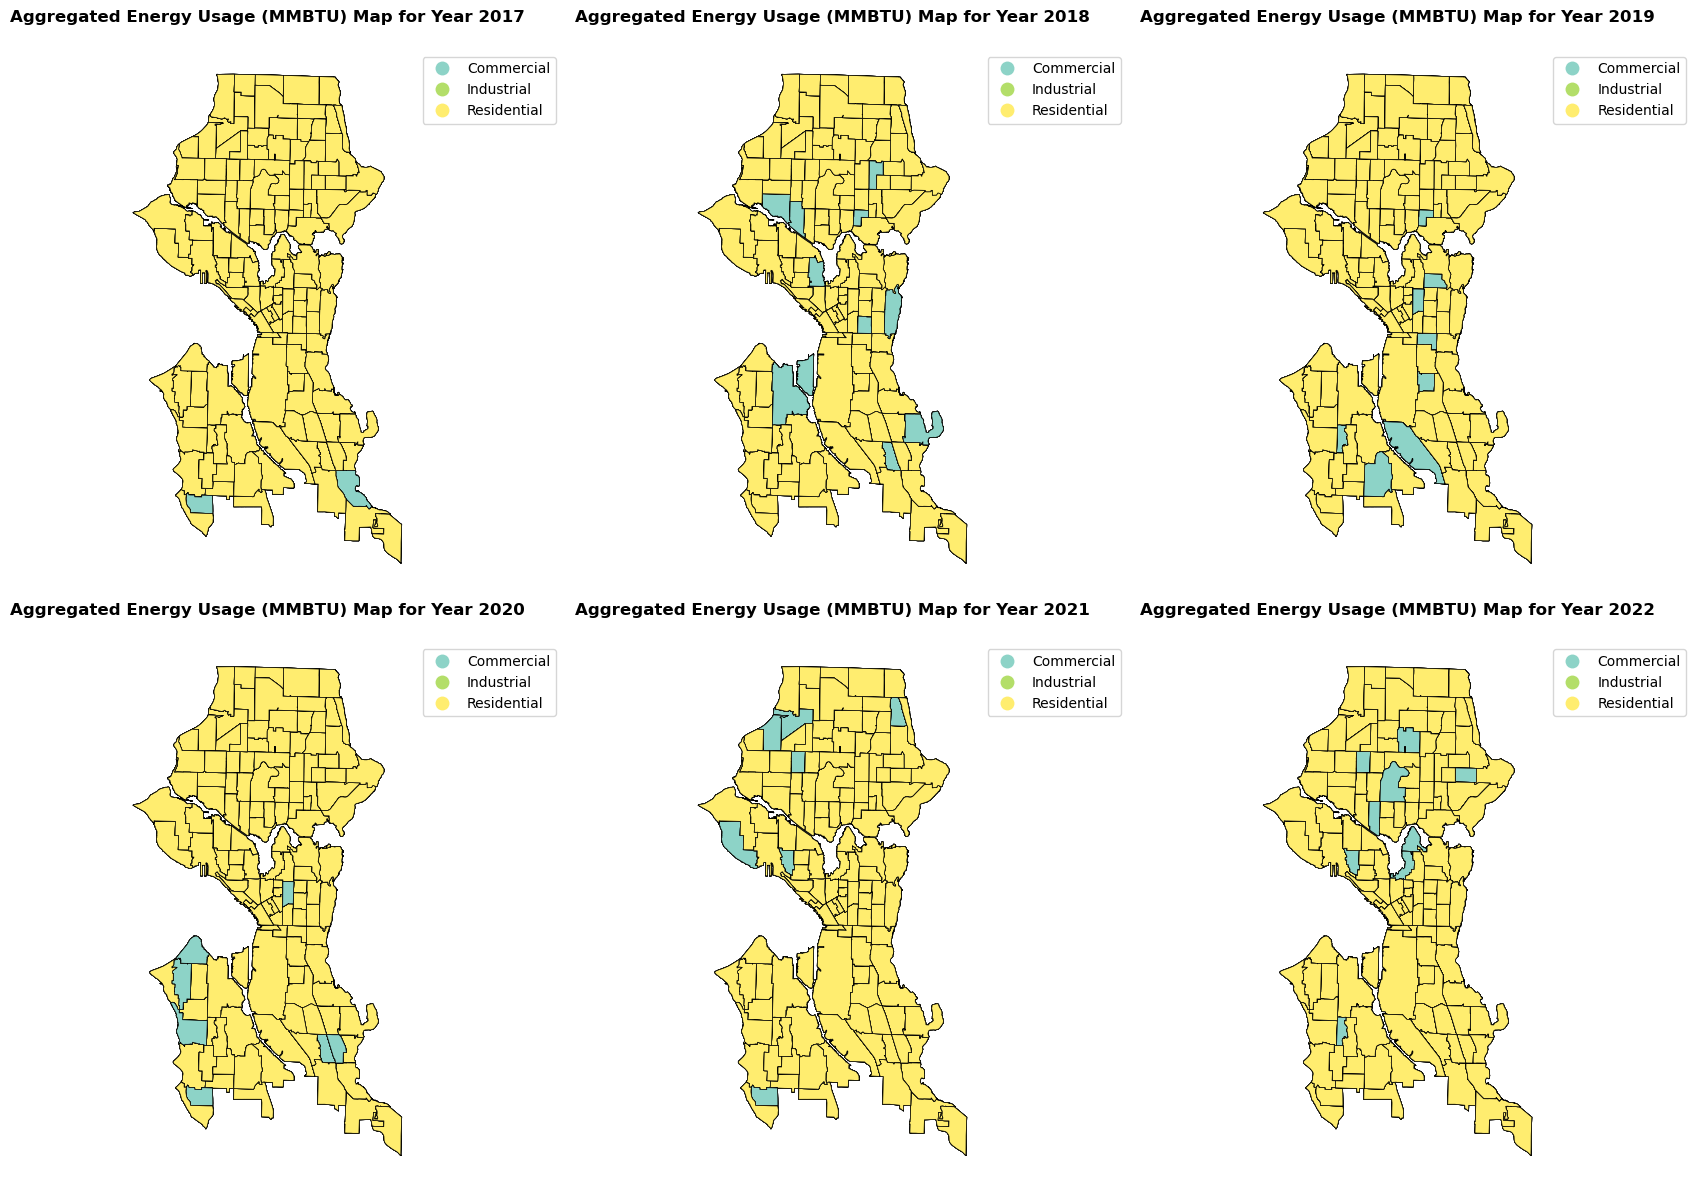

In [31]:
# Plot the geo data for energy usage

year_column = 'CAL_YEAR'
energy_column = 'USAGE_MMBT'
sector_column = 'Sector'
grpd_column = 'GRPD_NUMBE'

# Group by year, GRPD_NUMBE, and sector, and aggregate energy usage within each group
aggregated_data = geo_data.groupby([year_column, grpd_column, sector_column])[energy_column].sum().reset_index()

# Merge the aggregated data back into the geo data
geo_data_aggregated = geo_data.merge(aggregated_data, on=[year_column, grpd_column, sector_column])

# Plot the choropleth map for aggregated energy usage in the specific year, categorized by sector
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, year in enumerate(sorted(geo_data_aggregated[year_column].unique())):
    ax = axes[i]
    geo_data_year = geo_data_aggregated[geo_data_aggregated[year_column] == year]
    
    # Plot the choropleth map for aggregated energy usage in the specific year, categorized by sector
    geo_data_year.plot(ax=ax, column=sector_column, cmap='Set3', 
                       edgecolor='black', linewidth=0.5, legend=True)
    
    # Add title
    ax.set_title(f'Aggregated Energy Usage (MMBTU) Map for Year {int(year)}', size=12, weight='bold', pad=20)
    
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1.5, 1)) 
    
    # Remove the x and y labels of the maps
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Remove the rectangle shape around the maps
    for edge in ['right', 'left', 'bottom', 'top']:
        ax.spines[edge].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

I attempted to aggregate energy usage data based on both sector and grouped population numbers for each calendar year. However, the choropleth maps do not appear to accurately represent the data. As a next step, I plan to create plots specifically for energy usage and CO2 emissions based solely on the sector column for each calendar year.

#### Plot Energy Usage and CO2 Emissions

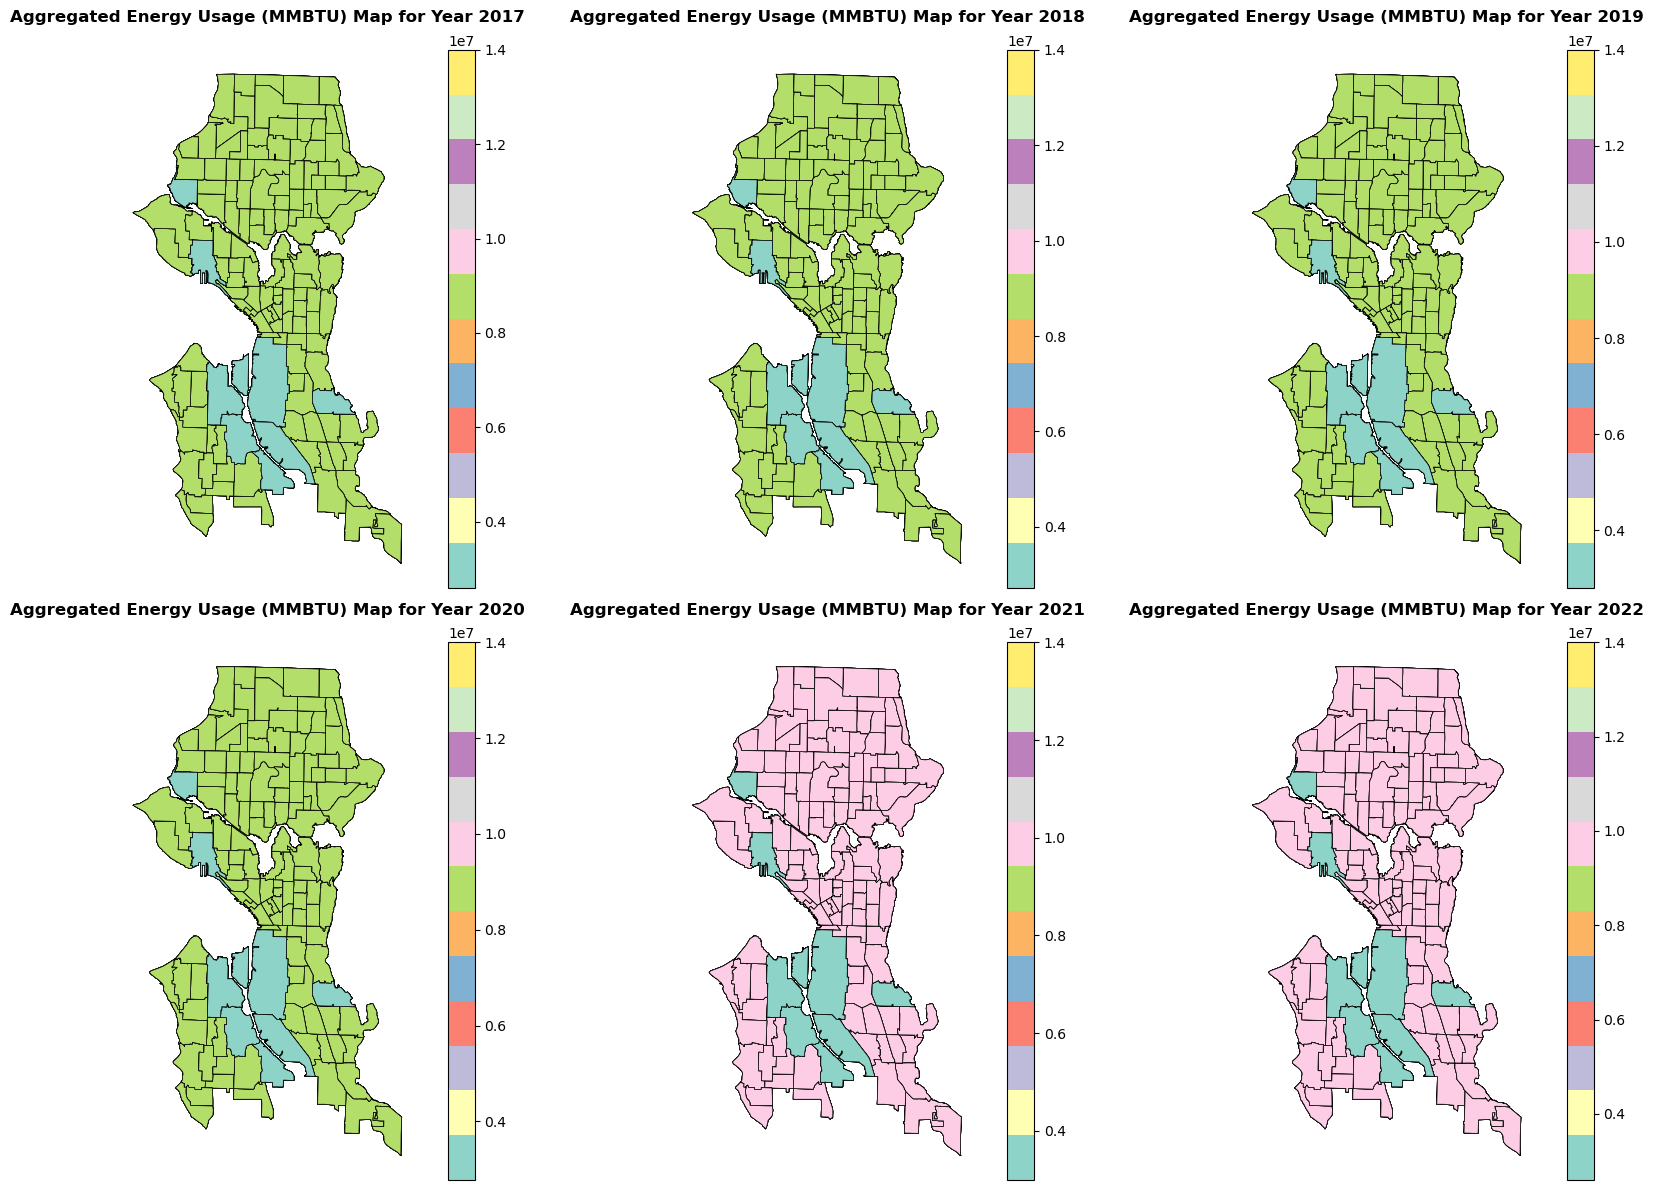

In [32]:
# Plot the geo data for energy usage

year_column = 'CAL_YEAR'
energy_column = 'USAGE_MMBT'
sector_column = 'Sector'

# Group by year and sector, and aggregate energy usage within each sector
aggregated_data = geo_data.groupby([year_column, sector_column])[energy_column].sum().reset_index()

# Merge the aggregated data back into the geo data
geo_data_aggregated = geo_data.merge(aggregated_data, on=[year_column, sector_column])

# Plot the choropleth map for aggregated energy usage in the specific year, categorized by sector
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, year in enumerate(sorted(geo_data_aggregated[year_column].unique())):
    ax = axes[i]
    geo_data_year = geo_data_aggregated[geo_data_aggregated[year_column] == year]
    
    # Plot the choropleth map for aggregated energy usage in the specific year, categorized by sector
    geo_data_year.plot(ax=ax, column=energy_column+'_y', cmap='Set3', 
                       edgecolor='black', linewidth=0.5, vmax=1.4e7, legend=True)
    
    ax.set_title(f'Aggregated Energy Usage (MMBTU) Map for Year {int(year)}', size=12, weight='bold', pad=20)
    
    #remove the x and y lebels of the maps
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #remove the rectangle shape around the maps
    for edge in ['right', 'left','bottom', 'top']:
        ax.spines[edge].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

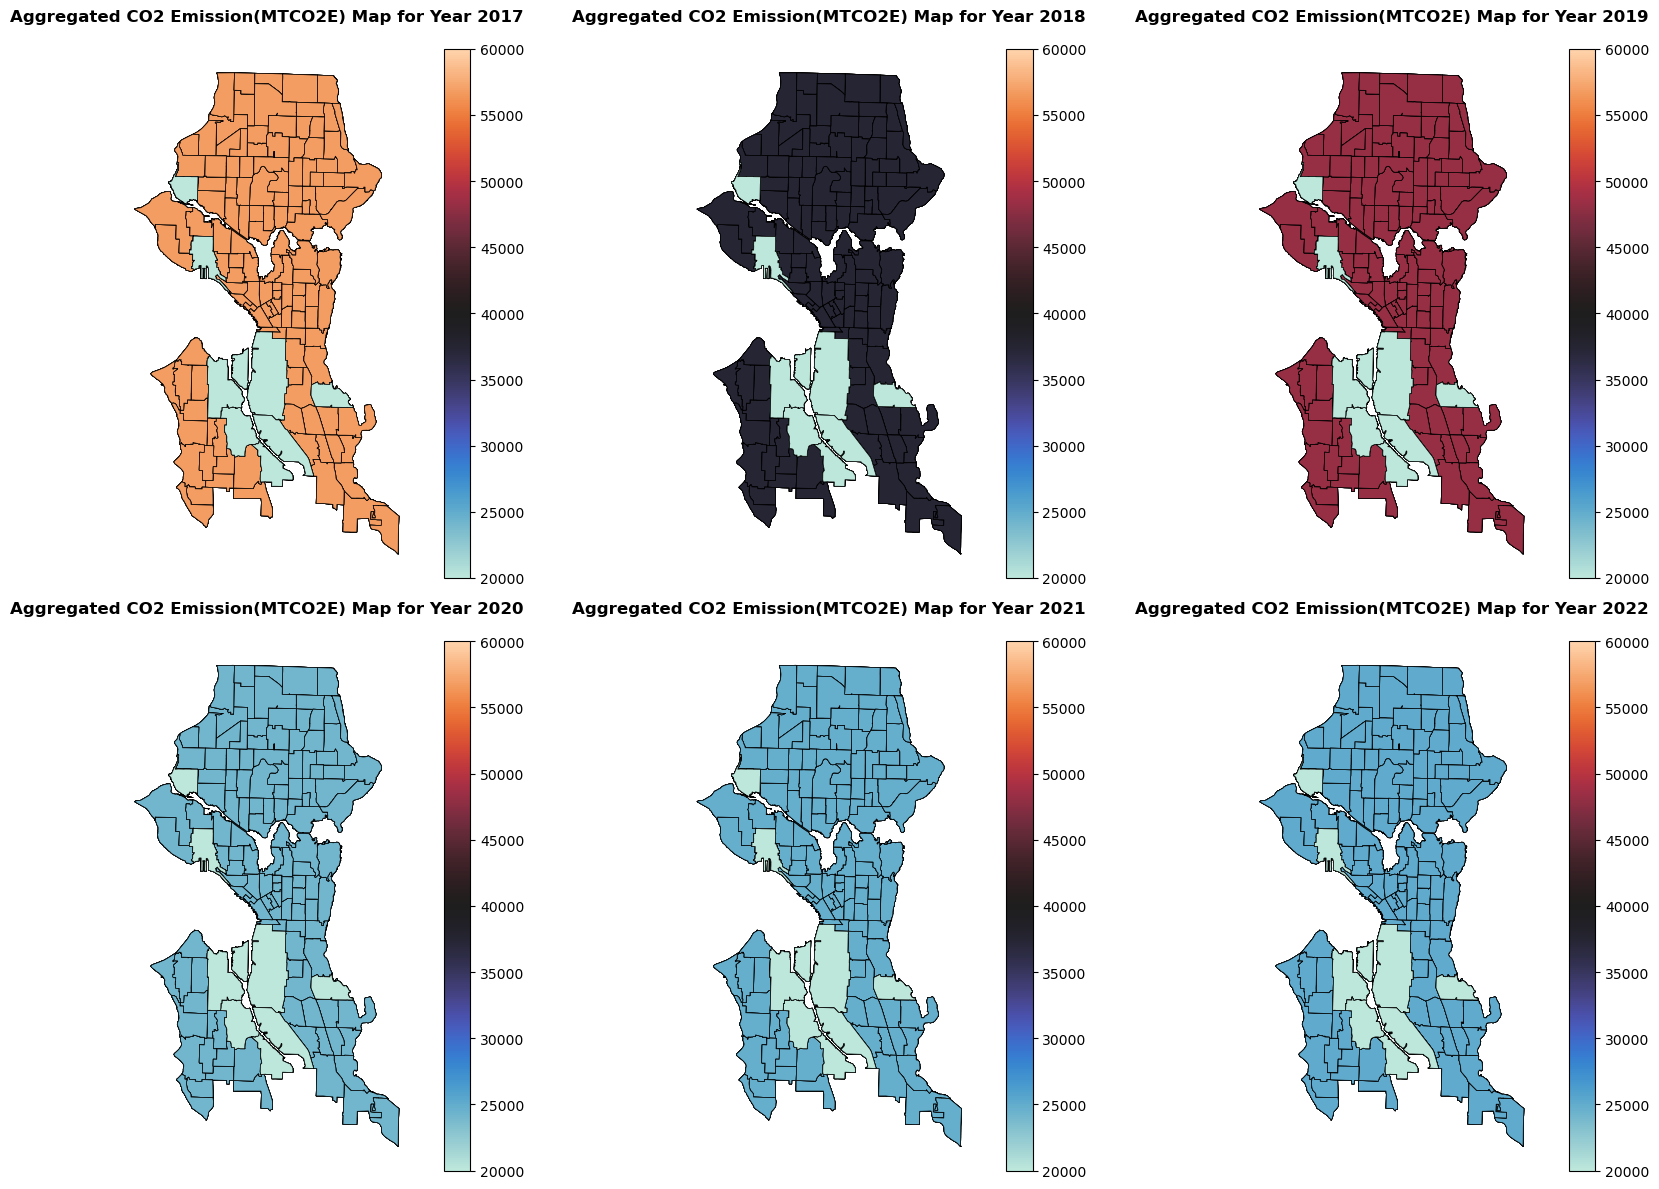

In [33]:
# Plot the geo data for CO2 emission

year_column = 'CAL_YEAR'
emission_column = 'EMISSIONS_'
sector_column = 'Sector'

# Group by year and sector, and aggregate CO2 emission within each sector
aggregated_data = geo_data.groupby([year_column, sector_column])[emission_column].sum().reset_index()

# Merge the aggregated data back into the geo data
geo_data_aggregated = geo_data.merge(aggregated_data, on=[year_column, sector_column])

# Plot the choropleth map for aggregated CO2 emission in the specific year, categorized by sector
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, year in enumerate(sorted(geo_data_aggregated[year_column].unique())):
    ax = axes[i]
    geo_data_year = geo_data_aggregated[geo_data_aggregated[year_column] == year]
    
    # Plot the choropleth map for aggregated CO2 emission in the specific year, categorized by sector
    geo_data_year.plot(ax=ax, column=emission_column+'_y', cmap='icefire', 
                       edgecolor='black', linewidth=0.5,vmin=20000, vmax=60000, legend=True)
    
    ax.set_title(f'Aggregated CO2 Emission(MTCO2E) Map for Year {int(year)}', size=12, weight='bold', pad=20)
    
    #remove the x and y lebels of the maps
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #remove the rectangle shape around the maps
    for edge in ['right', 'left','bottom', 'top']:
        ax.spines[edge].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

Due to privacy concerns, the geographic data for the commercial and residential sectors has been merged by the data source. This consolidation makes it challenging to represent three distinct colors on the choropleth maps for energy usage and CO2 emissions. Consequently, for a more in-depth analysis, I will explore the data further and employ alternative plotting methods.

### Percentages of Energy Usage and CO2 Emission

In [75]:
#Calculate percentages of energy usage and CO2 emission

#print('Energy Usage by Sector:')
energy_result_pivoted['energy_sum'] = energy_result_pivoted.sum(axis=1) - (energy_result_pivoted['energy_sum'])

print('Energy Usage Percentage by Sector:')
energy_percentage = energy_result_pivoted.div(energy_result_pivoted['energy_sum'], axis=0) * 100
energy_percentage = energy_percentage.drop(columns=['energy_sum'])
energy_percentage = energy_percentage.round(2)
#print(energy_percentage)

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}%'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(energy_percentage)



Energy Usage Percentage by Sector:


Sector,Commercial,Industrial,Residential
CAL_YEAR,,,
2017,58.60%,9.12%,32.29%
2018,58.17%,9.91%,31.92%
2019,57.94%,10.24%,31.83%
2020,55.77%,10.23%,34.00%
2021,55.50%,10.67%,33.83%
2022,55.65%,9.43%,34.92%


In [61]:
#print('CO2 Emission by Sector:')
emissions_result_pivoted['emission_sum'] = emissions_result_pivoted.sum(axis=1) - emissions_result_pivoted['emission_sum']
#print(emissions_result_pivoted)   

print('CO2 Emission Percentage by Sector:')  
emisson_percentage = emissions_result_pivoted.div(emissions_result_pivoted['emission_sum'], axis=0)  *100
emisson_percentage = emisson_percentage.drop(columns=['emission_sum'])
emisson_percentage = emisson_percentage.round(2)
#print(emisson_percentage)

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}%'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(emisson_percentage)

CO2 Emission Percentage by Sector:


Sector,Commercial,Industrial,Residential
CAL_YEAR,,,
2017,58.60%,9.12%,32.29%
2018,58.17%,9.91%,31.92%
2019,57.94%,10.24%,31.83%
2020,55.77%,10.23%,34.00%
2021,55.50%,10.67%,33.83%
2022,55.65%,9.43%,34.92%


The percentage tables for energy usage and CO2 emission yield identical results due to a direct proportionality between the amount of electricity consumed and the corresponding CO2 emissions within a specific category.

In [77]:
# Calculate percentage change of energy consumption
print('Yearly Energy Consumption % Change' )

energy_percentage_change = energy_result_pivoted.pct_change() * 100

# Set display options for cleaner output

pd.options.display.float_format = '{:.2f}%'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(energy_percentage_change)

Yearly Energy Consumption % Change


Sector,Commercial,Industrial,Residential,energy_sum
CAL_YEAR,,,,
2017,NaN,NaN,NaN,NaN
2018,-4.27%,4.86%,-4.66%,-3.57%
2019,-0.84%,2.81%,-0.74%,-0.45%
2020,-4.68%,-1.04%,5.77%,-0.98%
2021,2.94%,7.87%,2.94%,3.45%
2022,-1.67%,-13.28%,1.20%,-1.94%


In [76]:
# Calculate percentage change of CO2 emission

print('Yearly CO2 Emission % Change' )

emission_percentage_change = emissions_result_pivoted.pct_change() * 100

# Set display options for cleaner output
pd.options.display.float_format = '{:.2f}%'.format
pd.set_option('display.notebook_repr_html', True)

# Display the DataFrame
display(emission_percentage_change)

Yearly CO2 Emission % Change


Sector,Commercial,Industrial,Residential,emission_sum
CAL_YEAR,,,,
2017,NaN,NaN,NaN,NaN
2018,-33.84%,-27.52%,-34.10%,-33.35%
2019,28.62%,33.35%,28.75%,29.13%
2020,-54.97%,-53.25%,-50.03%,-53.22%
2021,2.94%,7.87%,2.94%,3.45%
2022,-1.67%,-13.28%,1.20%,-1.94%


## Conclusion

In this analysis of Seattle City Light electricity usage and CO2 emissions, I visualized trends over a 6-year period and drew several key observations:

1. **Consistent Energy Consumption**: Energy usage remained relatively stable across all sectors throughout the years, indicating consistent demand patterns.

2. **Industrial Dominance**: Industrial energy consumption per capita significantly exceeded that of residential and commercial sectors, highlighting the sector's higher energy needs.

3. **Pandemic Impact on Energy Usage**: In 2020, residential energy usage saw a notable increase (5.77%) likely due to increased time spent at home during COVID-19 lockdowns. Conversely, the commercial sector experienced its largest decrease (4.68%) as businesses shuttered during the pandemic. Industrial energy consumption remained relatively constant.

4. **CO2 Emission Trends**: CO2 emissions showed significant variation between 2017 and 2020, with the industrial sector witnessing the largest increase in 2019 and the commercial sector experiencing the largest decrease in 2020. Emissions remained relatively stable after the initial pandemic-induced disruptions.

5. **Continued Analysis**: Further investigation into factors driving energy consumption and emissions fluctuations, especially post-pandemic, can provide insights for sustainable energy planning and policy decisions.

6. **Future Trends**: While energy consumption remains stable across all sectors, there is a noticeable downward trend in CO2 emissions. This decline in emissions could be attributed to factors such as the growing presence of electric vehicles in the city, regulatory measures aimed at reducing emissions, and advancements in technology promoting energy-efficient products and production methods.





